## Anomaly & Detrend
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell

Will Wieder Feb. 2020

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal
import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

In [5]:
## User defined options
model = 'CLM5_GSWP3'
variables = ['GPP','NBP','TWS']
pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'
files = [pattern.format(var=var) for var in variables]
        
# Read in the data 
# utils.time_set_mid corrects dates, to get Jan of first year
ds = utils.time_set_mid(xr.open_mfdataset(files, combine='by_coords', decode_times=True), 'time') # combine needed for newer xarray versions

var = variables   #redundant, but we'll keep using this for now because 'var' is used more later on...
area = ds.area
landfrac = ds.landfrac
#print(ds.var)

In [6]:
# Select the time slice to analize,  here we'll do the last 25 years
# Use esmlab to calculate climatology & anomalies
# First we'll do this for every grid w/ monthly data

years = 25
months = years * 12

ds2 = ds.isel(time=slice(-months,None))             # Select last N years of data
ds_climo = esmlab.core.climatology(ds2,freq='mon')  # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom  = ds_anom.where(ds_anom.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables
print(ds_anom.dims)

Frozen(SortedKeysDict({'time': 300, 'lat': 192, 'lon': 288, 'hist_interval': 2, 'levgrnd': 25, 'levlak': 10, 'levdcmp': 25}))


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [7]:
# now remove trends from each grid cell
# detrend data using signal.detrend
# use apply_ufunc
# This works for just for one variable

def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})

dt_anom = dtrend(ds_anom.GPP.load().fillna(0), 'time')

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


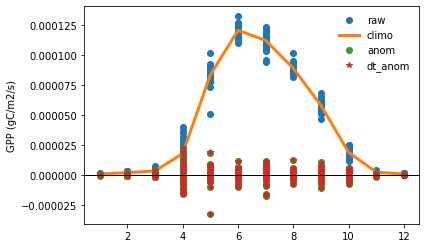

In [8]:
# quick look at a grid cell

ilat = 60
ilon = 240
plt.plot(ds2.time['time.month'], ds2['GPP'].sel(lat=ilat, lon=ilon, method='nearest'), 'o' )
plt.plot(ds_climo.time['time.month'], ds_climo['GPP'].sel(lat=ilat, 
                                                          lon=ilon, method='nearest'), '-', lw=3 )
plt.plot(ds_anom.time['time.month'], ds_anom['GPP'].sel(lat=ilat, 
                                                        lon=ilon, method='nearest'), 'o' )
plt.plot(dt_anom.time['time.month'], dt_anom.sel(lat=ilat, lon=ilon, method='nearest'), '*' )
plt.legend(labels=('raw','climo','anom','dt_anom'),frameon = False)
plt.axhline(0, color='black', lw=1)
plt.ylabel("GPP (gC/m2/s)");

### Global means, anomalies, & detrended anomalies
#### * These are still monthly results * 

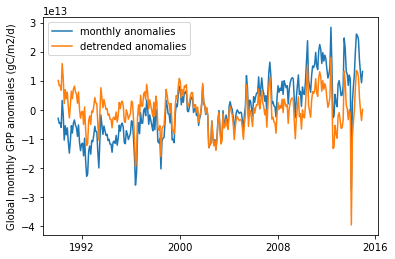

In [9]:
# mask out area for gridcells with no GPP for weights?
landUp = area * landfrac * 1e6 # area in km2, not m2
wgt = landUp / landUp.sum()    # weighting for each grid cell
spd = 3600 * 24        # Convert  to daily fluxes (gC/m2/d), from gc/m2/s 
spy = spd * 365

global_ts = esmlab.statistics.weighted_sum(ds2.GPP*landUp, dim=('lat','lon'))*spd
global_ts_anom = esmlab.statistics.weighted_sum(ds_anom.GPP*landUp, dim=('lat','lon'))*spd
global_ts_dt = signal.detrend(global_ts_anom)

# Then makes some plots
plt.plot(global_ts.time, global_ts_anom, '-' )
plt.plot(global_ts.time, global_ts_dt, '-' )
plt.ylabel("Global monthly GPP anomalies (gC/m2/d)")
plt.legend(labels=("monthly anomalies", "detrended anomalies"));

### Convert monthly to annual

<xarray.DataArray (time: 25, lat: 192, lon: 288)>
dask.array<mul, shape=(25, 192, 288), dtype=float64, chunksize=(25, 192, 288)>
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1990-12-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    units:    gC m-2 y-1
[115.83182242 115.15869757 112.85235243 114.92316293 114.05480004
 115.1866071  114.62268845 117.13412568 115.49125931 117.26893797
 119.334785   118.19690718 115.3763682  116.20857797 117.65856708
 118.32954254 120.26782701 119.86430742 120.72266914 120.46586301
 122.1697529  124.63990938 121.30831584 122.25063894 122.40474113]


Text(0, 0.5, 'Global annual GPP anomalies (PgC/y)')

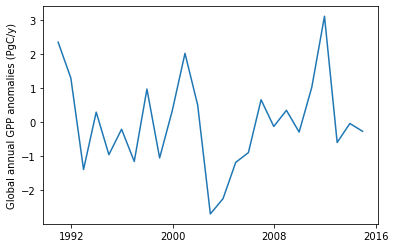

In [10]:
# These values don't make any sense, let's have a closer look.

# apply iterates through all variables in a dataset and applies the function to each variable.
# ?? Would be nice to do this differently for fluxes & stocks ??
ann_mean = utils.weighted_annual_mean(ds2['GPP']) * spy
ann_mean.attrs['units'] = 'gC m-2 y-1'
print(ann_mean)
#print(ds2.apply_ufunc(utils.weighted_annual_mean))

#ann_mean_anom  = esmlab.core.anomaly(ann_mean, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time

global_ann_ts = esmlab.statistics.weighted_sum(ann_mean*landUp, dim=('lat','lon'))*1e-15 #PgC y-1
global_ann_dt = signal.detrend(global_ann_ts)
#global_ann_dt.attrs['units'] = 'PgC y-1'
print(global_ann_ts.values)
#plt.plot(global_ann_ts.time, global_ann_ts, '-' )
plt.plot(global_ann_ts.time, global_ann_dt, '-' )
plt.ylabel("Global annual GPP anomalies (PgC/y)")


In [3]:
a = False
b = True
c = a*b
print(c)

0
